In [23]:
#importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, NuSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay, roc_auc_score, auc, accuracy_score, f1_score, confusion_matrix, mean_squared_error
from sklearn import tree 
import xgboost as xgb_package
import seaborn as sns

In [24]:
#reading files
all_pairs = pd.read_csv("all_pairs.csv", sep= ";")
all_pairs = all_pairs.dropna(how='all')              # drops fully empty rows
all_pairs = all_pairs.dropna(axis=1, how='all')      # drops fully empty columns

In [25]:
npos = len(all_pairs[all_pairs['neighbour biomarker for target?'] == 1])
print(npos)

332


In [26]:
# Defining positive control
training_pos =all_pairs[all_pairs['neighbour biomarker for target?'] == 1]

In [27]:
# Negative control = not biomarker in CIViCmine
training_neg = all_pairs[
    (all_pairs['neighbour biomarker for target?'] == 0) &
    (all_pairs['prognostic'] == 0) &
    (all_pairs['predisposing'] == 0) &
    (all_pairs['diagnostic'] == 0) &
    (all_pairs['predictive'] == 0)]
training_neg.shape

(548, 84)

In [28]:
training = pd.concat([training_pos, training_neg], ignore_index=True)

In [29]:
#titles list
titles = list(training.head())

IDP_bio = titles[5:17]
target_bio = titles[22:32]

CSN = [s for s in titles if "CSN" in s]
SIGNOR = [s for s in titles if "SIGNOR" in s]
ReactomeFI = [s for s in titles if "ReactomeFI" in s]

print(IDP_bio, target_bio)
print(CSN, SIGNOR, ReactomeFI)

['neighbour DisProt IDP', 'neighbour DisProt disorder content', 'neighbour in AlphaFold', 'neighbour AlphaFold average pLLDT', 'neighbour AlphaFold disorder %', 'neighbour in IUPred', 'neighbour IUPred long score', 'neighbour IUPred long disorder %', 'neighbour IUPred short score', 'neighbour IUPred short disorder %', 'neighbour preclinical target', 'neighbour MCG target'] ['target of small molecule', 'target of antibody', 'target DisProt IDP', 'target DisProt disorder content', 'target AlphaFold average pLLDT', 'target AlphaFold disorder %', 'target IUPred long score', 'target IUPred long disorder %', 'target IUPred short score', 'target IUPred short disorder %']
['neighbour in CSN', 'target in CSN', 'both in CSN', 'in triangle - CSN', 'no. of triangles - CSN', 'no. of in cycle - CSN', 'no. of in unbalanced triangle - CSN', 'neighbour – target inhibition - CSN', 'target – neighbour stimulation - CSN', 'neighbour – target stimulation - CSN', 'target – neighbour inhibition - CSN', 'DisP

In [30]:
#what to drop
to_drop = ["neighbour UniProt", "neighbour name - universal", "target UniProt", "target name - universal", 
           "prognostic", "predisposing", "diagnostic", "predictive"]
only_topo = to_drop + IDP_bio + target_bio
only_CSN = only_topo + SIGNOR + ReactomeFI
only_SIGNOR = only_topo + CSN + ReactomeFI 
only_ReactomeFI = only_topo + CSN + SIGNOR

In [31]:
#classifiers - hyperparameters optimalised
xgb = xgb_package.XGBClassifier(n_estimators=1000,
                                random_state=42,
                                subsample= 0.75,
                                scale_pos_weight= 0.25,
                                reg_lambda= 0,
                                reg_alpha= 0.5,
                                min_child_weight= 0.5,
                                max_leaves= 11,
                                max_depth= 7,
                                max_delta_step= 1,
                                max_bin= 32,
                                learning_rate= 1,
                                importance_type= 'cover',
                                grow_policy= 'lossguide',
                                gamma= 0.5,
                                criterion= 'log_loss',
                                booster= 'gbtree')
rfc = RandomForestClassifier(n_estimators=1000,
                             random_state= 42,
                             warm_start= False, #disabled, otherwise gives error with multiple training sets
                             oob_score= False,
                             n_jobs= 31,
                             min_weight_fraction_leaf= 0.1,
                             min_samples_split= 4,
                             min_samples_leaf= 5,
                             max_samples= 71,
                             max_leaf_nodes= 29,
                             max_features= 'sqrt',
                             max_depth= 3,
                             criterion= 'log_loss',
                             class_weight= 'balanced',
                             ccp_alpha= 0)

In [32]:
#data preparation
def prepare_data(drop_train, drop_test, training=training, test=training):
    """
    This function prepares the training and test data for the machine learning.
    Drops the previously selected columns using the drop_test list and renames the remaining columns.
    Splits the data to input parameters and labels.

    Args:
        drop_train: The list of column names which are going to be dropped from the training dataframe.
        drop_test: The list of column names which are going to be dropped from the test dataframe. 
        training: The dataframe of input parameters which are intended to use to the training of the machine learning model.
        test: The dataframe of input parameters which are intended to use to the testing of the machine learning model.

    Returns:
        X_train: The input data from the training dataframe.
        X_test: The input data from the test dataframe.
        y_train: The labels from the training dataframe.
        y_test: The labels from the test dataframe.

    """
    training_deleted = training.drop(columns= drop_train)
    training_deleted.columns = ['neighbour in network', 
                                'target in network', 
                                'both in network', 
                                'both in all 3',
                                'in triangle - network', 
                                'not in any triangle', 
                                'no. of triangles - network',
                                'no. of in cycle - network', 
                                'no. of in unbalanced triangle - network',
                                'neighbour – target inhibition - network',
                                'target – neighbour stimulation - network',
                                'neighbour – target stimulation - network',
                                'target – neighbour inhibition - network',
                                'DisProt neighbour third partner - network', 
                                'target third partner - network',
                                'neighbour bridgeness - network', 
                                'neighbour betweenness - network',
                                'target bridgeness - network', 
                                'target betweenness - network',
                                'neighbour biomarker for target?']
    X_train = training_deleted.iloc[:,:-1]
    y_train = training_deleted.iloc[:, -1]
    test_deleted = test.drop(columns= drop_test)
    test_deleted.columns = ['neighbour in network', 
                                'target in network', 
                                'both in network', 
                                'both in all 3',
                                'in triangle - network', 
                                'not in any triangle', 
                                'no. of triangles - network',
                                'no. of in cycle - network', 
                                'no. of in unbalanced triangle - network',
                                'neighbour – target inhibition - network',
                                'target – neighbour stimulation - network',
                                'neighbour – target stimulation - network',
                                'target – neighbour inhibition - network',
                                'DisProt neighbour third partner - network', 
                                'target third partner - network',
                                'neighbour bridgeness - network', 
                                'neighbour betweenness - network',
                                'target bridgeness - network', 
                                'target betweenness - network',
                                'neighbour biomarker for target?']
    X_test = test_deleted.iloc[:,:-1]
    y_test = test_deleted.iloc[:, -1]
    return X_train, X_test, y_train, y_test

In [33]:
#teaching - ROC/PR curve, scores
def teach_print_test_all(X_train, X_test, y_train, y_test, classifier, what):
    """
    This function teaches and tests the selected machine learning models while also calculating different metrics.
    Fits StandardScaler on the training data and transforms the training and test data.
    Makes predictions on the training and test dataframes.
    Calculates and returns accuracy, F1 score and ROC AUC.
    Based on selection, draws the ROC or PR curve.

    Args:
        X_train: The input data which will be used for training the model.
        X_test: The input data which will be used for testing the model.
        y_train: The labels for the X_train dataframe.
        y_test: The labels for the X_test dataframe.
        classifier: The choosen classification algorhythm.
        what: The selected graph drawn based on the performance of the classificator. Options: "ROC" or "PR".

    Returns:
        classifier_pred_train: Predictions on the training dataset.
        classifier_pred_test: Predictions on the test dataset.
        display: The display of the choosen graph.
        params: The list of the calculated metrics, such as accuracy, FR score, ROC AUC.

    """
    #fitting the scale
    scale = StandardScaler()
    scale.fit(X_train)
    X_train = scale.transform(X_train)
    X_test = scale.transform(X_test)
        
    #teaching
    classifier.fit(X_train, y_train)

    classifier_pred_train = classifier.predict(X_train)
    classifier_pred_test = classifier.predict(X_test)
    
    #accuracy+f1+auc
    acc = accuracy_score(y_test, classifier_pred_test)
    f1 = f1_score(y_test, classifier_pred_test)
    test_auc = roc_auc_score(y_test, classifier_pred_test)
    params= [acc, f1, test_auc]
    print(f"Accuracy: {acc}\n F1 score: {f1}\n Test AUC: {test_auc}")  
    print(params)    
    
    #test ROC curve
    if what == "ROC":
        ax1 = plt.gca()
        display = RocCurveDisplay.from_estimator(classifier, X_test, y_test, ax=ax1, alpha=0.8)
        #plt.show()
    
    #precision recall
    elif what == "PR":
        ax2 = plt.gca()
        display = PrecisionRecallDisplay.from_estimator(classifier, X_test, y_test, ax=ax2, alpha=0.8)
        #plt.show() 
        
    else: 
        print("Please give a valid option.")
    
    return classifier_pred_train, classifier_pred_test, display, params

In [34]:
def params_heatmap(params_xgb, params_rfc):
    """
    This function draws heatmap based on the performance metrics of the XGBoost and Random Forest algorhythms.
    Puts the input parameters into a dictionary, then into a dataframe.
    Transposes the dataframe to make the heatmap more easily understandable.
    Sets the name of the columns based on the name of the parameters: "Accuracy", "F1-score", "Test AUC score".
    Draws the heatmap.
    Returms the dataframe of the parameters.

    Args:
        params_xgb: Accuracy, F1-score, test AUC score for the XGBoost algorhythm.
        params_rfc: Accuracy, F1-score, test AUC score for the Random Forest algorhythm.

    Returns:
        params: Dataframe of the XGBoost and Random forest parameters.

    """
    params_dict = {'XGBoost': params_xgb, 'Random forest': params_rfc}
    print(dict)
    params = pd.DataFrame(params_dict)
    params = params.transpose()
    params = params.set_axis(["Accuracy", "F1-score", "Test AUC score"], axis=1)
    sns.heatmap(params, annot=True)
    print(params)
    return params

XGBoost results:
[18:45:30] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Accuracy: 0.8272727272727273
 F1 score: 0.7853107344632769
 Test AUC: 0.8292586404010202
[0.8272727272727273, 0.7853107344632769, 0.8292586404010202]
Random forest results:
Accuracy: 0.775
 F1 score: 0.7676056338028169
 Test AUC: 0.8163749890071234
[0.775, 0.7676056338028169, 0.8163749890071234]


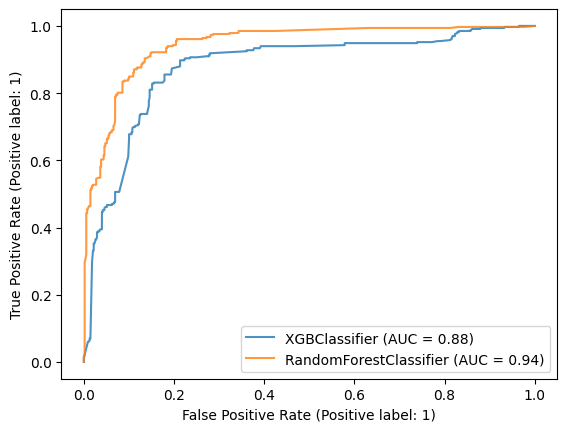

XGBoost results:
[18:45:33] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Accuracy: 0.8272727272727273
 F1 score: 0.7853107344632769
 Test AUC: 0.8292586404010202
[0.8272727272727273, 0.7853107344632769, 0.8292586404010202]
Random forest results:
Accuracy: 0.775
 F1 score: 0.7676056338028169
 Test AUC: 0.8163749890071234
[0.775, 0.7676056338028169, 0.8163749890071234]


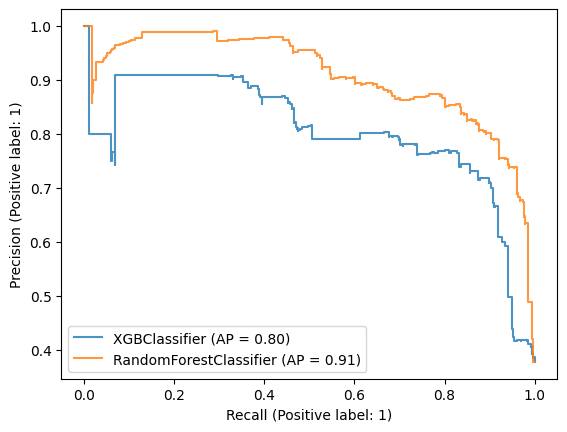

<class 'dict'>
               Accuracy  F1-score  Test AUC score
XGBoost        0.827273  0.785311        0.829259
Random forest  0.775000  0.767606        0.816375


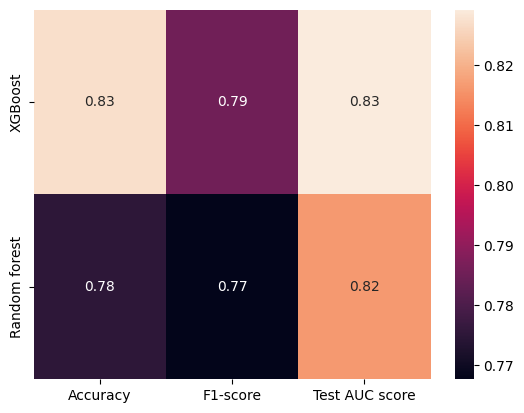

In [35]:
#CSN-SIGNOR
#ROC
X_train_CSN, X_test_SIGNOR, y_train_CSN, y_test_SIGNOR = prepare_data(drop_train=only_CSN, drop_test=only_SIGNOR)
print("XGBoost results:")
xgb_pred_train, xgb_pred_test, display_xgb_CSN_SIGNOR, params_xgb_CSN_SIGNOR = teach_print_test_all(X_train_CSN, X_test_SIGNOR, 
                                                                                       y_train_CSN, y_test_SIGNOR, 
                                                                                       classifier=xgb, what="ROC")
print("Random forest results:")
rfc_pred_train, rfc_pred_test, display_rfc_CSN_SIGNOR, params_rfc_CSN_SIGNOR = teach_print_test_all(X_train_CSN, X_test_SIGNOR, 
                                                                                      y_train_CSN, y_test_SIGNOR, 
                                                                                      classifier=rfc, what="ROC")
plt.plot(data= [display_xgb_CSN_SIGNOR, display_rfc_CSN_SIGNOR])
plt.show()
#PR
print("XGBoost results:")
xgb_pred_train, xgb_pred_test, display_xgb_CSN_SIGNOR, params_xgb_CSN_SIGNOR = teach_print_test_all(X_train_CSN, X_test_SIGNOR, 
                                                                                      y_train_CSN, y_test_SIGNOR, 
                                                                                      classifier=xgb, what="PR")
print("Random forest results:")
rfc_pred_train, rfc_pred_test, display_rfc_CSN_SIGNOR, params_rfc_CSN_SIGNOR = teach_print_test_all(X_train_CSN, X_test_SIGNOR, 
                                                                                      y_train_CSN, y_test_SIGNOR, 
                                                                                      classifier=rfc, what="PR")
plt.plot(data= [display_xgb_CSN_SIGNOR, display_rfc_CSN_SIGNOR])
plt.show()
#heatmap
params_df_CSN_SIGNOR = params_heatmap(params_xgb=params_xgb_CSN_SIGNOR, params_rfc=params_rfc_CSN_SIGNOR)

XGBoost results:
[18:45:35] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Accuracy: 0.8102272727272727
 F1 score: 0.7012522361359571
 Test AUC: 0.7668960513587195
[0.8102272727272727, 0.7012522361359571, 0.7668960513587195]
Random forest results:
Accuracy: 0.7977272727272727
 F1 score: 0.6751824817518248
 Test AUC: 0.7503297862984787
[0.7977272727272727, 0.6751824817518248, 0.7503297862984787]


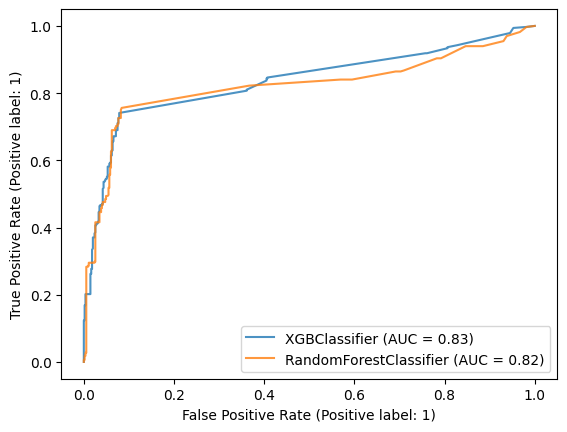

XGBoost results:
[18:45:37] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Accuracy: 0.8102272727272727
 F1 score: 0.7012522361359571
 Test AUC: 0.7668960513587195
[0.8102272727272727, 0.7012522361359571, 0.7668960513587195]
Random forest results:
Accuracy: 0.7977272727272727
 F1 score: 0.6751824817518248
 Test AUC: 0.7503297862984787
[0.7977272727272727, 0.6751824817518248, 0.7503297862984787]


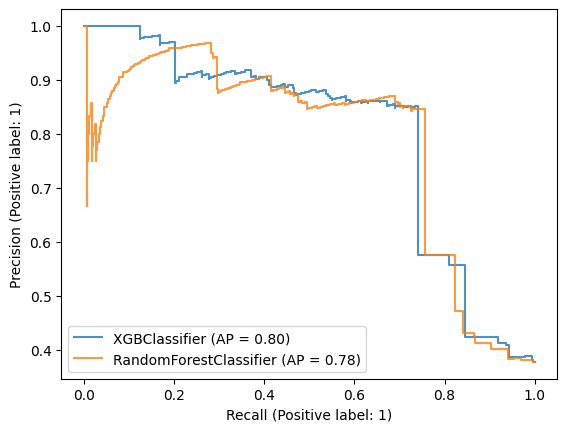

<class 'dict'>
               Accuracy  F1-score  Test AUC score
XGBoost        0.810227  0.701252        0.766896
Random forest  0.797727  0.675182        0.750330


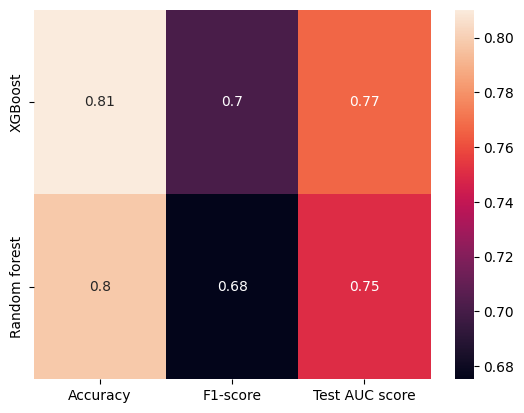

In [36]:
#SIGNOR_CSN
#ROC
X_train_SIGNOR, X_test_CSN, y_train_SIGNOR, y_test_CSN = prepare_data(drop_train=only_SIGNOR, drop_test=only_CSN)
print("XGBoost results:")
xgb_pred_train, xgb_pred_test, display_xgb_SIGNOR_CSN, params_xgb_SIGNOR_CSN = teach_print_test_all(X_train_SIGNOR, X_test_CSN, 
                                                                                       y_train_SIGNOR, y_test_CSN, 
                                                                                       classifier=xgb, what="ROC")
print("Random forest results:")
rfc_pred_train, rfc_pred_test, display_rfc_SIGNOR_CSN, params_rfc_SIGNOR_CSN = teach_print_test_all(X_train_SIGNOR, X_test_CSN, 
                                                                                      y_train_SIGNOR, y_test_CSN, 
                                                                                      classifier=rfc, what="ROC")
plt.plot(data= [display_xgb_SIGNOR_CSN, display_rfc_SIGNOR_CSN])
plt.show()
#PR
print("XGBoost results:")
xgb_pred_train, xgb_pred_test, display_xgb_SIGNOR_CSN, params_xgb_SIGNOR_CSN = teach_print_test_all(X_train_SIGNOR, X_test_CSN, 
                                                                                      y_train_SIGNOR, y_test_CSN, 
                                                                                      classifier=xgb, what="PR")
print("Random forest results:")
rfc_pred_train, rfc_pred_test, display_rfc_SIGNOR_CSN, params_rfc_SIGNOR_CSN = teach_print_test_all(X_train_SIGNOR, X_test_CSN, 
                                                                                      y_train_SIGNOR, y_test_CSN, 
                                                                                      classifier=rfc, what="PR")
plt.plot(data= [display_xgb_SIGNOR_CSN, display_rfc_SIGNOR_CSN])
plt.show()
#heatmap
params_df_SIGNOR_CSN = params_heatmap(params_xgb=params_xgb_SIGNOR_CSN, params_rfc=params_rfc_SIGNOR_CSN)

XGBoost results:
[18:45:40] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Accuracy: 0.6147727272727272
 F1 score: 0.6116838487972508
 Test AUC: 0.6521084337349398
[0.6147727272727272, 0.6116838487972508, 0.6521084337349398]
Random forest results:
Accuracy: 0.45681818181818185
 F1 score: 0.5662431941923776
 Test AUC: 0.551996306393457
[0.45681818181818185, 0.5662431941923776, 0.551996306393457]


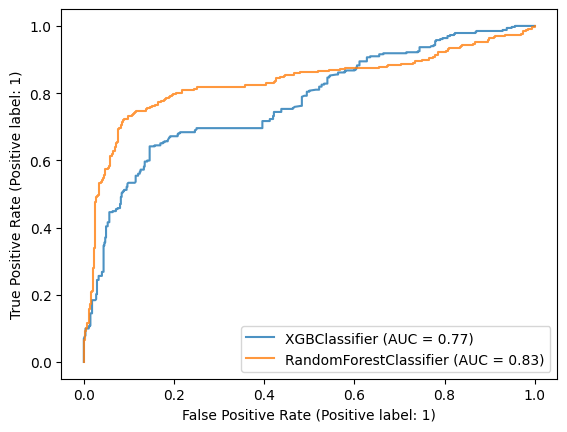

XGBoost results:
[18:45:42] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Accuracy: 0.6147727272727272
 F1 score: 0.6116838487972508
 Test AUC: 0.6521084337349398
[0.6147727272727272, 0.6116838487972508, 0.6521084337349398]
Random forest results:
Accuracy: 0.45681818181818185
 F1 score: 0.5662431941923776
 Test AUC: 0.551996306393457
[0.45681818181818185, 0.5662431941923776, 0.551996306393457]


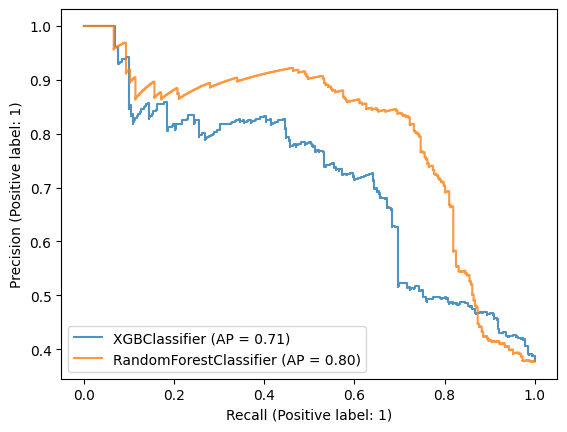

<class 'dict'>
               Accuracy  F1-score  Test AUC score
XGBoost        0.614773  0.611684        0.652108
Random forest  0.456818  0.566243        0.551996


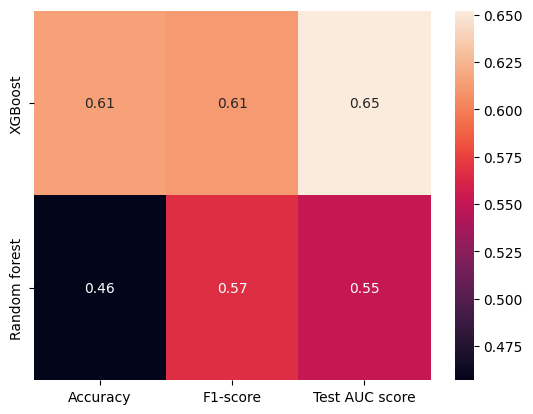

In [37]:
#SIGNOR_ReactomeFI
#ROC
X_train_SIGNOR, X_test_ReactomeFI, y_train_SIGNOR, y_test_ReactomeFI = prepare_data(drop_train=only_SIGNOR, drop_test=only_ReactomeFI)
print("XGBoost results:")
xgb_pred_train, xgb_pred_test, display_xgb_SIGNOR_ReactomeFI, params_xgb_SIGNOR_ReactomeFI = teach_print_test_all(X_train_SIGNOR, X_test_ReactomeFI, 
                                                                                       y_train_SIGNOR, y_test_ReactomeFI, 
                                                                                       classifier=xgb, what="ROC")
print("Random forest results:")
rfc_pred_train, rfc_pred_test, display_rfc_SIGNOR_ReactomeFI, params_rfc_SIGNOR_ReactomeFI = teach_print_test_all(X_train_SIGNOR, X_test_ReactomeFI, 
                                                                                      y_train_SIGNOR, y_test_ReactomeFI, 
                                                                                      classifier=rfc, what="ROC")
plt.plot(data= [display_xgb_SIGNOR_ReactomeFI, display_rfc_SIGNOR_ReactomeFI])
plt.show()
#PR
print("XGBoost results:")
xgb_pred_train, xgb_pred_test, display_xgb_SIGNOR_ReactomeFI, params_xgb_SIGNOR_ReactomeFI = teach_print_test_all(X_train_SIGNOR, X_test_ReactomeFI, 
                                                                                      y_train_SIGNOR, y_test_ReactomeFI, 
                                                                                      classifier=xgb, what="PR")
print("Random forest results:")
rfc_pred_train, rfc_pred_test, display_rfc_SIGNOR_ReactomeFI, params_rfc_SIGNOR_ReactomeFI = teach_print_test_all(X_train_SIGNOR, X_test_ReactomeFI, 
                                                                                      y_train_SIGNOR, y_test_ReactomeFI, 
                                                                                      classifier=rfc, what="PR")
plt.plot(data= [display_xgb_SIGNOR_ReactomeFI, display_rfc_SIGNOR_ReactomeFI])
plt.show()
#heatmap
params_df_SIGNOR_ReactomeFI = params_heatmap(params_xgb=params_xgb_SIGNOR_ReactomeFI, params_rfc=params_rfc_SIGNOR_ReactomeFI)

XGBoost results:
[18:45:44] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Accuracy: 0.7511363636363636
 F1 score: 0.5389473684210527
 Test AUC: 0.6790849529504881
[0.7511363636363636, 0.5389473684210527, 0.6790849529504881]
Random forest results:
Accuracy: 0.8613636363636363
 F1 score: 0.7903780068728522
 Test AUC: 0.828137366986193
[0.8613636363636363, 0.7903780068728522, 0.828137366986193]


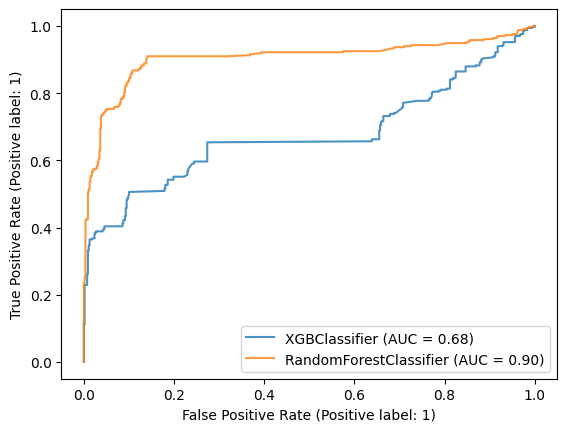

XGBoost results:
[18:45:47] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Accuracy: 0.7511363636363636
 F1 score: 0.5389473684210527
 Test AUC: 0.6790849529504881
[0.7511363636363636, 0.5389473684210527, 0.6790849529504881]
Random forest results:
Accuracy: 0.8613636363636363
 F1 score: 0.7903780068728522
 Test AUC: 0.828137366986193
[0.8613636363636363, 0.7903780068728522, 0.828137366986193]


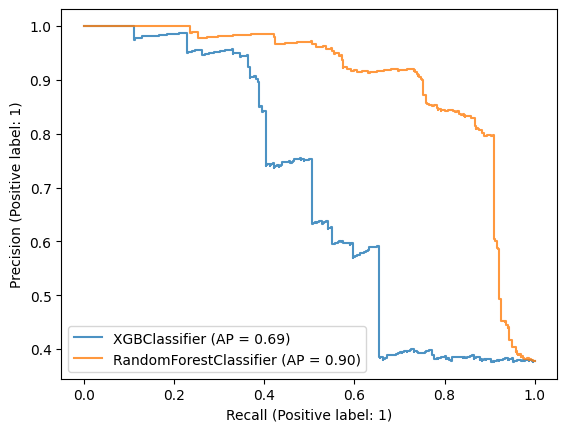

<class 'dict'>
               Accuracy  F1-score  Test AUC score
XGBoost        0.751136  0.538947        0.679085
Random forest  0.861364  0.790378        0.828137


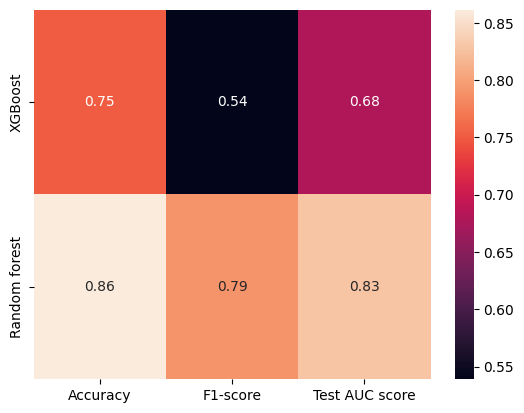

In [38]:
#ReactomeFI-SIGNOR
#ROC
X_train_ReactomeFI, X_test_SIGNOR, y_train_ReactomeFI, y_test_SIGNOR = prepare_data(drop_train=only_ReactomeFI, drop_test=only_SIGNOR)
print("XGBoost results:")
xgb_pred_train, xgb_pred_test, display_xgb_ReactomeFI_SIGNOR, params_xgb_ReactomeFI_SIGNOR = teach_print_test_all(X_train_ReactomeFI, X_test_SIGNOR, 
                                                                                       y_train_ReactomeFI, y_test_SIGNOR, 
                                                                                       classifier=xgb, what="ROC")
print("Random forest results:")
rfc_pred_train, rfc_pred_test, display_rfc_ReactomeFI_SIGNOR, params_rfc_ReactomeFI_SIGNOR = teach_print_test_all(X_train_ReactomeFI, X_test_SIGNOR, 
                                                                                      y_train_ReactomeFI, y_test_SIGNOR, 
                                                                                      classifier=rfc, what="ROC")
plt.plot(data= [display_xgb_ReactomeFI_SIGNOR, display_rfc_ReactomeFI_SIGNOR])
plt.show()
#PR
print("XGBoost results:")
xgb_pred_train, xgb_pred_test, display_xgb_ReactomeFI_SIGNOR, params_xgb_ReactomeFI_SIGNOR = teach_print_test_all(X_train_ReactomeFI, X_test_SIGNOR, 
                                                                                      y_train_ReactomeFI, y_test_SIGNOR, 
                                                                                      classifier=xgb, what="PR")
print("Random forest results:")
rfc_pred_train, rfc_pred_test, display_rfc_ReactomeFI_SIGNOR, params_rfc_ReactomeFI_SIGNOR = teach_print_test_all(X_train_ReactomeFI, X_test_SIGNOR, 
                                                                                      y_train_ReactomeFI, y_test_SIGNOR, 
                                                                                      classifier=rfc, what="PR")
plt.plot(data= [display_xgb_ReactomeFI_SIGNOR, display_rfc_ReactomeFI_SIGNOR])
plt.show()
#heatmap
params_df_ReactomeFI_SIGNOR = params_heatmap(params_xgb=params_xgb_ReactomeFI_SIGNOR, params_rfc=params_rfc_ReactomeFI_SIGNOR)

XGBoost results:
[18:45:49] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Accuracy: 0.6681818181818182
 F1 score: 0.5933147632311977
 Test AUC: 0.6629364172016532
[0.6681818181818182, 0.5933147632311977, 0.6629364172016532]
Random forest results:
Accuracy: 0.3795454545454545
 F1 score: 0.545
 Test AUC: 0.4988567408319409
[0.3795454545454545, 0.545, 0.4988567408319409]


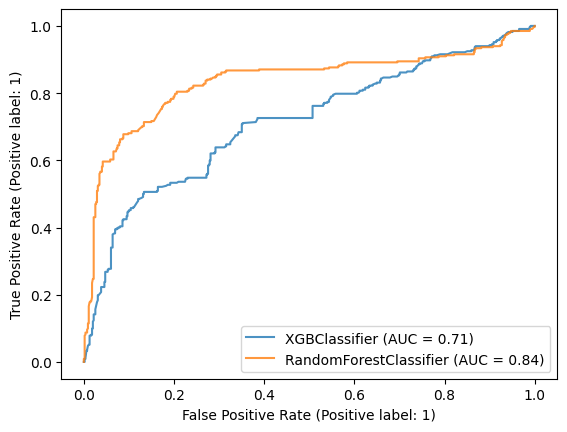

XGBoost results:
[18:45:51] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Accuracy: 0.6681818181818182
 F1 score: 0.5933147632311977
 Test AUC: 0.6629364172016532
[0.6681818181818182, 0.5933147632311977, 0.6629364172016532]
Random forest results:
Accuracy: 0.3795454545454545
 F1 score: 0.545
 Test AUC: 0.4988567408319409
[0.3795454545454545, 0.545, 0.4988567408319409]


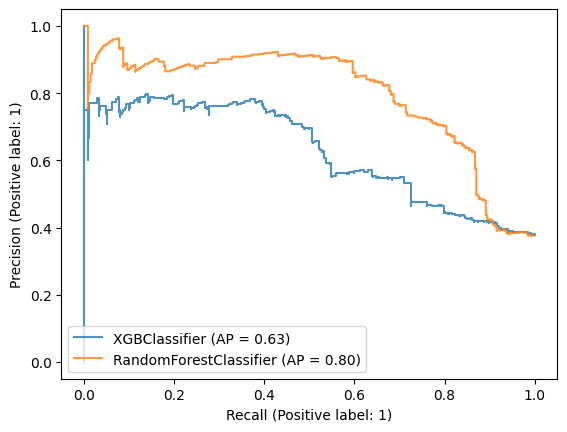

<class 'dict'>
               Accuracy  F1-score  Test AUC score
XGBoost        0.668182  0.593315        0.662936
Random forest  0.379545  0.545000        0.498857


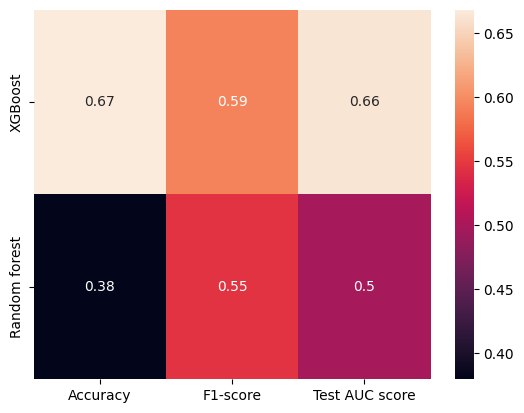

In [39]:
#CSN-ReactomeFI
#ROC
X_train_CSN, X_test_ReactomeFI, y_train_CSN, y_test_ReactomeFI = prepare_data(drop_train=only_CSN, drop_test=only_ReactomeFI)
print("XGBoost results:")
xgb_pred_train_, xgb_pred_test, display_xgb_CSN_ReactomeFI, params_xgb_CSN_ReactomeFI = teach_print_test_all(X_train_CSN, X_test_ReactomeFI, 
                                                                                       y_train_CSN, y_test_ReactomeFI, 
                                                                                       classifier=xgb, what="ROC")
print("Random forest results:")
rfc_pred_train, rfc_pred_test, display_rfc_CSN_ReactomeFI, params_rfc_CSN_ReactomeFI = teach_print_test_all(X_train_CSN, X_test_ReactomeFI, 
                                                                                      y_train_CSN, y_test_ReactomeFI, 
                                                                                      classifier=rfc, what="ROC")
plt.plot(data= [display_xgb_CSN_ReactomeFI, display_rfc_CSN_ReactomeFI])
plt.show()
#PR
print("XGBoost results:")
xgb_pred_train, xgb_pred_test, display_xgb_CSN_ReactomeFI, params_xgb_CSN_ReactomeFI = teach_print_test_all(X_train_CSN, X_test_ReactomeFI, 
                                                                                      y_train_CSN, y_test_ReactomeFI, 
                                                                                      classifier=xgb, what="PR")
print("Random forest results:")
rfc_pred_train, rfc_pred_test, display_rfc_CSN_ReactomeFI, params_rfc_CSN_ReactomeFI = teach_print_test_all(X_train_CSN, X_test_ReactomeFI, 
                                                                                      y_train_CSN, y_test_ReactomeFI, 
                                                                                      classifier=rfc, what="PR")
plt.plot(data= [display_xgb_CSN_ReactomeFI, display_rfc_CSN_ReactomeFI])
plt.show()
#heatmap
params_df_CSN_ReactomeFI = params_heatmap(params_xgb=params_xgb_CSN_ReactomeFI, params_rfc=params_rfc_CSN_ReactomeFI)

XGBoost results:
[18:45:53] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Accuracy: 0.7670454545454546
 F1 score: 0.5807770961145193
 Test AUC: 0.7001692902998857
[0.7670454545454546, 0.5807770961145193, 0.7001692902998857]
Random forest results:
Accuracy: 0.7306818181818182
 F1 score: 0.45265588914549654
 Test AUC: 0.6448531351684109
[0.7306818181818182, 0.45265588914549654, 0.6448531351684109]


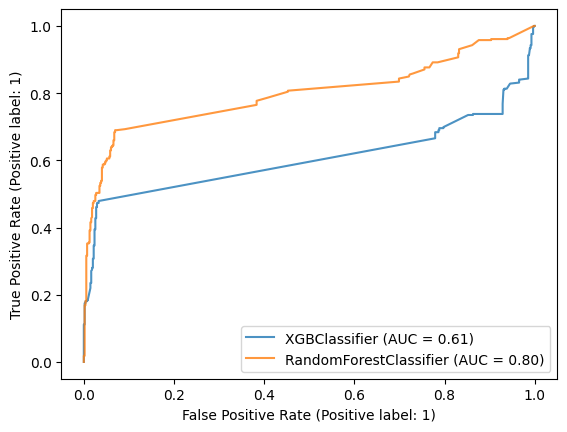

XGBoost results:
[18:45:56] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Accuracy: 0.7670454545454546
 F1 score: 0.5807770961145193
 Test AUC: 0.7001692902998857
[0.7670454545454546, 0.5807770961145193, 0.7001692902998857]
Random forest results:
Accuracy: 0.7306818181818182
 F1 score: 0.45265588914549654
 Test AUC: 0.6448531351684109
[0.7306818181818182, 0.45265588914549654, 0.6448531351684109]


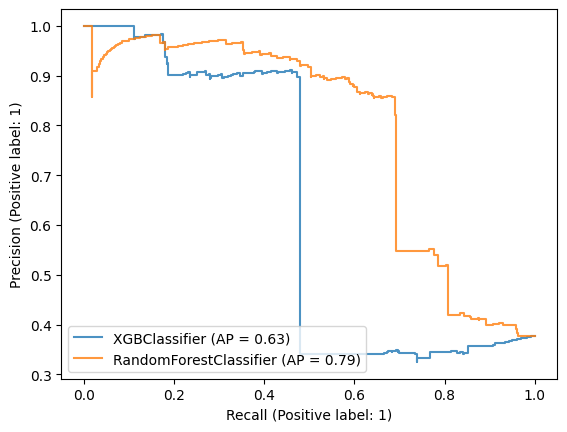

<class 'dict'>
               Accuracy  F1-score  Test AUC score
XGBoost        0.767045  0.580777        0.700169
Random forest  0.730682  0.452656        0.644853


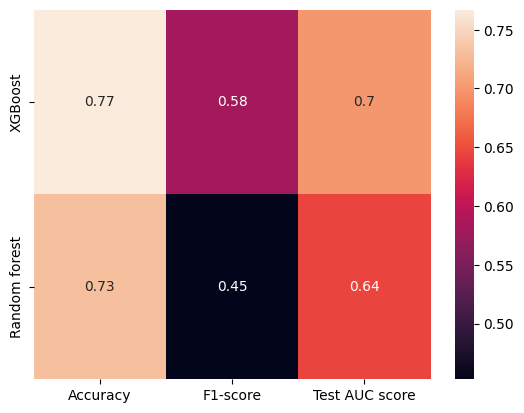

In [40]:
#ReactomeFI_CSN
#ROC
X_train_ReactomeFI, X_test_CSN, y_train_ReactomeFI, y_test_CSN = prepare_data(drop_train=only_ReactomeFI, drop_test=only_CSN)
print("XGBoost results:")
xgb_pred_train, xgb_pred_test, display_xgb_ReactomeFI_CSN, params_xgb_ReactomeFI_CSN = teach_print_test_all(X_train_ReactomeFI, X_test_CSN, 
                                                                                       y_train_ReactomeFI, y_test_CSN, 
                                                                                       classifier=xgb, what="ROC")
print("Random forest results:")
rfc_pred_train, rfc_pred_test, display_rfc_ReactomeFI_CSN, params_rfc_ReactomeFI_CSN = teach_print_test_all(X_train_ReactomeFI, X_test_CSN, 
                                                                                      y_train_ReactomeFI, y_test_CSN, 
                                                                                      classifier=rfc, what="ROC")
plt.plot(data= [display_xgb_ReactomeFI_CSN, display_rfc_ReactomeFI_CSN])
plt.show()
#PR
print("XGBoost results:")
xgb_pred_train, xgb_pred_test, display_xgb_ReactomeFI_CSN, params_xgb_ReactomeFI_CSN = teach_print_test_all(X_train_ReactomeFI, X_test_CSN, 
                                                                                      y_train_ReactomeFI, y_test_CSN, 
                                                                                      classifier=xgb, what="PR")
print("Random forest results:")
rfc_pred_train, rfc_pred_test, display_rfc_ReactomeFI_CSN, params_rfc_ReactomeFI_CSN = teach_print_test_all(X_train_ReactomeFI, X_test_CSN, 
                                                                                      y_train_ReactomeFI, y_test_CSN, 
                                                                                      classifier=rfc, what="PR")
plt.plot(data= [display_xgb_ReactomeFI_CSN, display_rfc_ReactomeFI_CSN])
plt.show()
#heatmap
params_df_ReactomeFI_CSN = params_heatmap(params_xgb=params_xgb_ReactomeFI_CSN, params_rfc=params_rfc_ReactomeFI_CSN)

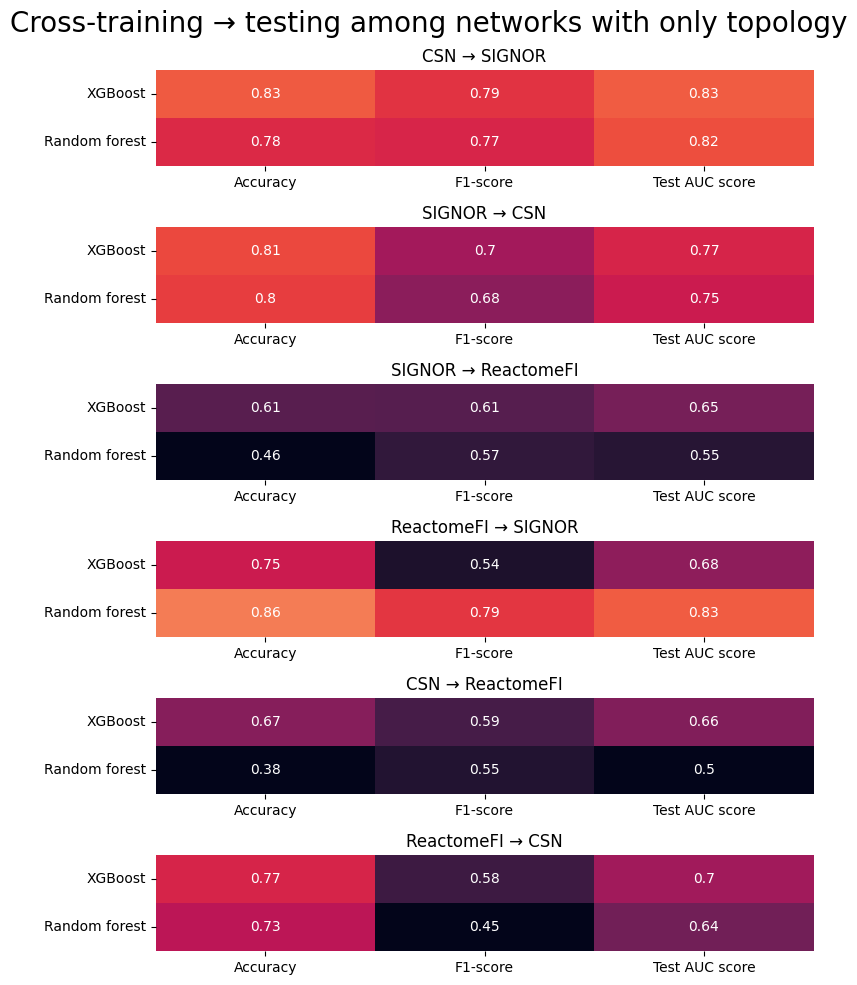

In [42]:
plt.rcParams["figure.figsize"] = [8, 10]
plt.rcParams["figure.autolayout"] = True

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=6, sharey=False)
fig.subplots_adjust(wspace=0.02)

vmin = 0.5
vmax = 1

plt.suptitle("Cross-training → testing among networks with only topology", fontsize=20)

sns.heatmap(params_df_CSN_SIGNOR, annot=True, ax=ax1, cbar=False, vmin=vmin, vmax=vmax)
ax1.set_title('CSN → SIGNOR')
sns.heatmap(params_df_SIGNOR_CSN, annot=True, ax=ax2, cbar=False, vmin=vmin, vmax=vmax)
ax2.set_title('SIGNOR → CSN')
sns.heatmap(params_df_SIGNOR_ReactomeFI, annot=True, ax=ax3, cbar=False, vmin=vmin, vmax=vmax)
ax3.set_title('SIGNOR → ReactomeFI')
sns.heatmap(params_df_ReactomeFI_SIGNOR, annot=True, ax=ax4, cbar=False, vmin=vmin, vmax=vmax)
ax4.set_title('ReactomeFI → SIGNOR')
sns.heatmap(params_df_CSN_ReactomeFI, annot=True, ax=ax5, cbar=False, vmin=vmin, vmax=vmax)
ax5.set_title('CSN → ReactomeFI')
sns.heatmap(params_df_ReactomeFI_CSN, annot=True, ax=ax6, cbar=False, vmin=vmin, vmax=vmax)
ax6.set_title('ReactomeFI → CSN')

plt.show()